## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('landing_page =="new_page" and group !="treatment"').shape[0] + df.query('landing_page !="new_page" and group =="treatment"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# indentify all rows where landing page and group coloumns don't match
unmatchedCol = df.query('landing_page =="new_page" and group !="treatment"') + df.query('landing_page !="new_page" and group =="treatment"')

In [9]:
# drop the rows identified above by their index position
df2 = df.drop(unmatchedCol.index, axis =0)

In [10]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# drop duplicate values in 'user_id' column, keeping first row of data
df2.drop_duplicates(subset ="user_id",keep='first',inplace=True)

In [16]:
# check all duplicated 'users_id', rows have been removed
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# The probability of a individual converting, would be the equivalent to the proportion 
# of all users that converted  
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
# calculate the proportion of users which landed on the 'new_page', 
# with all users that visited the site
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The overall probability of a user converting, regardless of the page they received, was found to be 0.12 (or 12%), and the number of unique users were evenly split between the two landing pages (50% treatment and 50% control).**

**Considering the probability for an individual converting from the treatment page was found to be approx. 0.12, and those landing on the control page also approx. 0.12, we can assume there is insufficient evidence that the treatment page leads to more conversions.**


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**On the assumption the old page is better, unless the new page proves to be definitely better, at a type one error rate of 5%. The following hypothesis test can be stated:**
<br><b>

Where,

**$p_{old}$** = Population mean returned from old page

**$p_{new}$** = Population mean returned from new page

$\alpha$ (alpha) = 0.05  
<br>

Null Hypothesis ($H_{0}$): New page has less or equal traffic to the old page.

$H_{0}$: **$p_{new}$** $\leq$  **$p_{old}$**

Alternative Hypothesis ($H_{1}$): New page has greater traffic than the old page.   

$H_{1}$: **$p_{new}$**> **$p_{old}$**

<br>

Or rearranged:

$H_{0}$: **$p_{new}$**- **$p_{old}$** $\leq$ 0

Difference of means from old to new is equal to or less than zero – ie **no difference**. 

$H_{1}$: **$p_{new}$** - **$p_{old}$** > 0

Difference of means from old to new is above zero – ie a **notable difference**.  

<br>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
# As we assume under the null, that both P_old and P_new have true success rates EQUAL to 
# the converted success rate, we can calculate the proportion of the converted for both.  
P_new = df2.converted.mean()
P_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
P_old = df2.converted.mean()
P_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
# As we have alreday removed duplicate users from df2, we can calculate the number in the 
# treatment group
N_new = df2.query('group =="treatment"').shape[0]
N_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
N_old = df2.query('group =="control"').shape[0]
N_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# draw N_old random samples, using numpy's random.binomial function, with P_new as probability 
# of success, for 1 trial.
new_page_converted = np.random.binomial(1, P_new, size = N_new)
new_page_converted.mean()

0.12211134815222628

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# as above, now with N_old and P_old parameters
old_page_converted = np.random.binomial(1, P_old, size = N_old)
old_page_converted.mean()

0.12046890703085204

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# calculate the difference between 'new_page_converted' and 'old_page_converted' means, but only use 145274 entries
# from new_page, to match those number of individuals returned from the control group (N_old) 
new_page_converted[:145274].mean() - old_page_converted.mean()

0.001658934152016192

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, P_new, size = N_new)
    old_page_converted = np.random.binomial(1, P_old, size = N_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

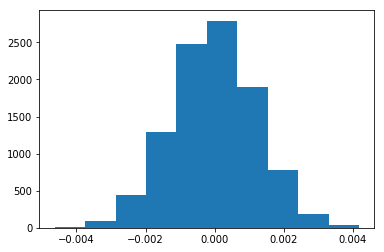

In [29]:
plt.hist(p_diffs);

***The plot looks as expected, that the simulation was carried out under the Null, resulting in a normal distribution, with a mean of 0.***

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# first calculate obs_diff(observed differnce) between the 'treatment' and 'control' groups of the 'ab_data' dataset
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diff

-0.0015782389853555567

In [31]:
# convert p_diffs list into array, and then find proportion of p_diffs greater than obs_diff
p_diffs = np.array(p_diffs)

(p_diffs > obs_diff).mean()

0.8977

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<b>
The value computed above, is the ‘P-Value’, and it was calculated in the following way:

A simulation was carried out of the values under the Null, made using our statistics (**$p_{new}$** and **$p_{old}$**).

The observed difference (obs_diffs), between the ‘control’ and ‘treatment’ groups was calculated from our actual original data.

The proportion between the simulation (p_diffs) and actual observed difference (obs_diffs), provided the P-Value.

<br>

The P-Value here of 0.9, is extremely high, and a lot higher than our type one error threshold rate, $\alpha$  = .05. 
This is evidence that our statistic was likely to have come from the Null Hypothesis ($H_{0}$), and therefore we do not have evidence to reject the Null Hypothesis as there is no notable difference between the new and old pages. Therefore, we fail to reject the Null Hypothesis ($H_{0}$).

$H_{0}$: **$p_{new}$**- **$p_{old}$** $\leq$ 0


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

# aggregate converted from both 'control' and 'treatment' groups 
convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
# count users in both groups
n_old = df2.query('group == "control"').user_id.count()
n_new = df2.query('group == "treatment"').user_id.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
# Where the number of successes are, 'convert_new','convert_old', and the number of trials
# n_new, n_old.
# As two sample test, using alternative ='larger' - ie p1 > p2 where p1 is the proportion of 
# the first sample and p2 of the second one. 
zstat, p_value =  sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
zstat, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<b>The Z-score is the number of standard deviations the actual data point (e.g. obs_diffs), is from the mean.

Since our Null Hypothesis states: the new page has less or equal traffic to the old page, or the difference of means from old to new is equal to or less than zero.

We can conclude that because we have a negative Z-score, the observed difference data point, falls below the mean of the normal distribution, and we therefore fail to reject the Null Hypothesis.

Further, the Z-score of -1.3, means the conversion rates from the old to the new pages, is negative. In other words, there is a reduced conversion rate for the new page compared to the old page. 

Though not tested for here, this observed reduction however does not appear to be statistically significant, as the Z-value was less than critical alpha value of -1.96 (the lower limit for a two tailed test - where alpha = .05, and consequently .025% in each tail) 

The P-value here is computed to be the same as that of the manual process and findings in parts j. and k. above, and therefore the conclusions are of course the same – we fail to reject the Null Hypothesis.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**As there are only two possible outcomes, Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# create the dummy variable columns for pages users receive.
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

# create new column 'ab_page' mirrored from 'treatment', and drop 'treatment' (not required),
# and 'control'(to create Full rank matrix).
df2['ab_page'] = df2['treatment']
df2 = df2.drop(['control', 'treatment'], axis=1)

# create 'intercept' comlumn
df2['intercept'] = 1

df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        10:46:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

<b>
As we have now introduced an intercept, the P-value here of 0.19, is now lower than that calculated above of 0.9.<br>

Our previous Null Hypothesis was; the new page has less or equal traffic to the old page.

Here our Null Hypothesis is; the new page traffic is equal to the old page traffic.

i.e.

Null Hypothesis
$H_{0}$: **$p_{new}$** $=$  **$p_{old}$**


Alternative Hypothesis
$H_{1}$: **$p_{new}$ $\neq$ $p_{old}$**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<b>
Other things to consider that may influence whether or not a user converts:

- Novelty effect and change aversion, when users first experience changes.
- Sufficient traffic and conversion, to have significant and repeatable results.
- Was the experiment run for long enough, to account for time of day, and day of week?
- Were there any population imbalances between each group, which may lead to situations like Simpson's paradox?

We could consider adding additional items to better understand the data, for example the day and time the user visited the landing page, and location (city/country) of users.

A potential disadvantage of adding additional terms into our regression model, is we may introduce Multicollinearity into our model. Where the predictor variables are correlated with each other, rather than the response variable.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# join countries_df with df2, "on" 'user_id'
countries_df2 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
countries_df2.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [39]:
# count all the unique countries within the dataset 
countries_df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
# create the dummy variables 
countries_df2[['US', 'UK', 'CA']] = pd.get_dummies(countries_df2['country'])
countries_df2.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [41]:
# create intercept
countries_df2['intercept']=1

# fit the model, dropping one dummy variable - in this case CA, as it has the lowest count.
log_mod = sm.Logit(countries_df2['converted'], countries_df2[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               2.323e-05
Time:                        10:47:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [42]:
# As Logistic regression is used here, we need to exponentiate each of the coefficients
np.exp(-0.0408), np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

<b>
As both the US and UK coefficients are relative to the CA (Canada), we can say, there is approx. a 4% less chance of US users converting to the new page, and 1% greater chance of UK users switching to the new site, than Canadian users. However, considering the large P-Values for both the US and UK, we have evidence that the results are statistically insignificant.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
# create new interaction coloumns between ab_page and each of the three countries
countries_df2['UK_ab_page'] = countries_df2['UK'] * countries_df2['ab_page']
countries_df2['US_ab_page'] = countries_df2['US'] * countries_df2['ab_page']
countries_df2['CA_ab_page'] = countries_df2['CA'] * countries_df2['ab_page']


In [44]:
# fit the new interaction model, dropping one dummy variable - in this case CA.
log_mod_interaction = sm.Logit(countries_df2['converted'], countries_df2[['intercept', 'ab_page', 'US', 'US_ab_page', 'UK', 'UK_ab_page']])
results_interaction = log_mod_interaction.fit()
results_interaction.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               3.482e-05
Time:                        10:48:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

<b>
From the above Logistic regression model, we can see each of the P-Values associated with our new interaction variables are all very high. This is evidence that the results are not statistically significant.


<b>
Conclusions:

We have seen evidence from several methods above (the 0.9 P-Values - of both the manual walkthrough method and results from the 'stats.proportions_ztest' - the -1.31 Z-Score, and the Logistic Regression models) to be confident that we fail to reject the Null Hypothesis. That is, the new page does not have increased traffic compared to that of the old page. In fact, the new page appears to have a slight decrease in traffic compared to the old page, though as noted above, this does not appear to be statistically significant. 
Considering all the evidence above, it would be advisable not to proceed with the new page.


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0